# 数据处理的学习记录

In [24]:
import torchvision
import torch 
import torch.nn as nn
import torchaudio
import torchmetrics
import librosa  
import numpy as np
#%matplotlib widget
print('Prerequisites Prepared')

Prerequisites Prepared


(None, 22050)

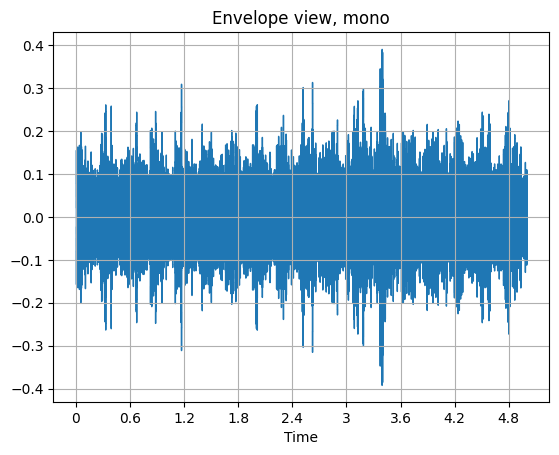

In [29]:
from librosa.display import waveshow
import matplotlib.pyplot as plt
y,sr = librosa.load('./0/0_0/0_0_1.wav')
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(y, sr=sr)
ax.set(title='Envelope view, mono')#mono单声道
ax.label_outer()
ax.grid(True),sr

In [12]:
import scipy.signal as signal
y_analytic = signal.hilbert(y)
y_analytic

array([ 0.06211947-0.0477347j ,  0.09874517+0.00047119j,
        0.09551786+0.03609874j, ..., -0.01353097-0.01115011j,
        0.00501827-0.0105214j ,  0.0050594 -0.03249865j], dtype=complex64)

 ### 为什么这里librosa绘制包络有负值?

Text(0.5, 1.0, 'envelope by librosa, mono')

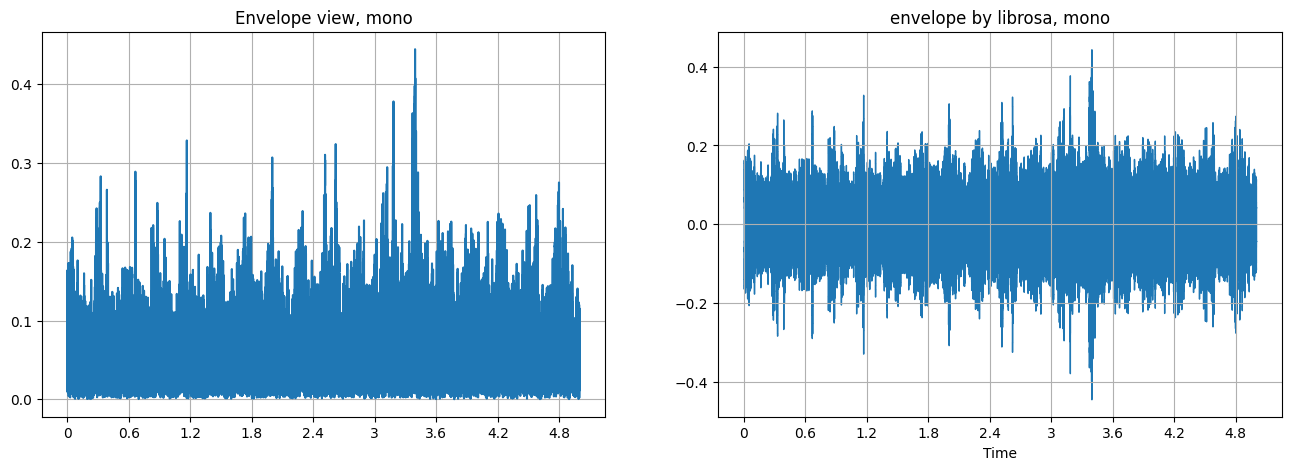

In [33]:
y_enve = np.abs(y_analytic)
y_enve

t = np.linspace(0, len(y)/sr, len(y))
fig,axes = plt.subplots(nrows=1,ncols=2, sharex=True)

fig.set_size_inches(16, 5)
axes[0].plot(t,y_enve)
axes[0].grid()
axes[0].set_title('Envelope view, mono')
librosa.display.waveshow(y_enve, sr=sr)#显示有问题
axes[1].grid()
axes[1].set_title('envelope by librosa, mono')

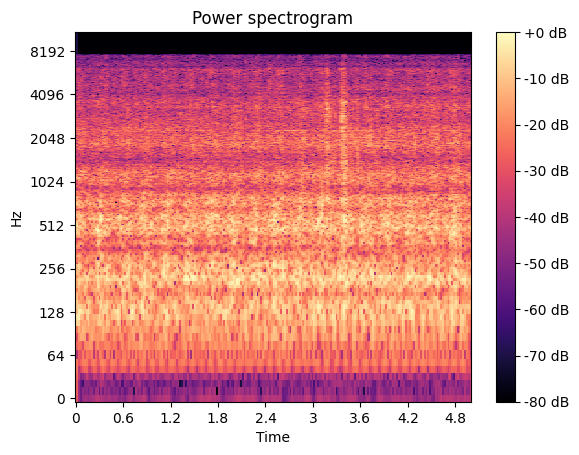

In [7]:
S = librosa.stft(y)

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(S),ref=np.max),y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

## 定义shipsear数据集

In [40]:
from torch.utils.data import Dataset,DataLoader
import os
class ShipsearSet(Dataset):
    def __init__(self,data_root,num_classes):
        super().__init__()
        self.num_classes = num_classes
        relative_path  = "E:\\MTQP\\wjy_codes\\shipsear_5s_16k\\"
        self.data = []
        with open(data_root,'r') as f:
            for line in f:
                tmp= line.removeprefix(relative_path )[6:-1]
                wav,label = tmp.split('\t')
                self.data.append((os.path.join(wav[0],wav[0:3],wav),int(label)))

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,idx):
        y,sr= librosa.load(self.data[idx][0])
        return torch.tensor(y),self.data[idx][1]


#### 加载shipsear数据集

In [46]:
#加载数据集
train_dataset = ShipsearSet(data_root = "train_list.txt",num_classes = 5)
test_dataset = ShipsearSet(data_root = "test_list.txt",num_classes = 5)

train_data = DataLoader(train_dataset,batch_size=4,shuffle=True)


#### 将音频数据转换到梅尔域

In [55]:
train_wav,labels = next(iter(train_data))
import torchaudio.transforms as T

# 创建梅尔谱变换器
mel_spectrogram = T.MelSpectrogram(
    sample_rate=16000,      # 采样率
    n_fft=1024,            # FFT窗口大小
    hop_length=512,         # 帧移
    n_mels=128,            # 梅尔滤波器组数量
    f_min=0,               # 最小频率
    f_max=8000,            # 最大频率
    window_fn=torch.hann_window  # 窗口函数
)

# train_wav 的形状是 [4, 110250]

# 转换为梅尔谱
mel_spec = mel_spectrogram(train_wav)
mel_spec = mel_spec.unsqueeze(1)

print(f"梅尔谱形状: {mel_spec.shape}")

梅尔谱形状: torch.Size([4, 1, 128, 216])


#### 定义模型结构

In [74]:
from torch import nn
class Net(nn.Module):
    def __init__(self):
        super().__init__()  #输入数据为梅尔谱，大小为[batch_size,1,128,216]
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,padding=1,stride=1)#->[batch_size,32,128,216]
        self.conv2 = nn.Conv2d(32,64,kernel_size=10,padding=5,stride=2)#->[batch_size,64,65,109]

        self.pool = nn.MaxPool2d(kernel_size=5,stride=4)#[batch_size, 64, 15, 26]    # kernel=5, stride=4
        self.conv3 = nn.Conv2d(64,1,kernel_size=3,padding=1,stride=1)#[batch_size, 390] 

        self.faltten = nn.Flatten()

        self.MLP = nn.Sequential(
                            nn.Linear(432,1024),
                            nn.LeakyReLU(),
                            nn.Linear(1024,512),
                            nn.LeakyReLU(),
                            nn.Linear(512,5)
                            )


    def forward(self,x):
        #卷积层
        x = self.conv1(x)
        x = nn.functional.leaky_relu(x)
        x = self.conv2(x)
        x = nn.functional.leaky_relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = nn.functional.leaky_relu(x)

        #线性层
        x = self.faltten(x)
        x = self.MLP(x)
        x = nn.functional.softmax(x, dim=1)  # 修正：需要指定维度

        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(10, 10), stride=(2, 2), padding=(5, 5))
  (pool): MaxPool2d(kernel_size=5, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (faltten): Flatten(start_dim=1, end_dim=-1)
  (MLP): Sequential(
    (0): Linear(in_features=432, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)


#### 训练模型

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(),lr=0.001)

loss_criterion = nn.CrossEntropyLoss()

for epoch in range(100):
    for data in train_data:
        optimizer.zero_grad()
        inputs,labels = data
        preds = net(inputs)

        loss = loss_criterion(preds,labels)
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch}:, Loss: {loss.item()}")

#### 评估模型

In [88]:
import torchmetrics
net.eval()
metric = torchmetrics.Accuracy(task="multiclass",num_classes=5)

test_data = DataLoader(test_dataset,batch_size=1,shuffle=True)
for data in test_data:
    wav,labels = data
    mel_spec = mel_spectrogram(wav)
    mel_spec = mel_spec.unsqueeze(0)
    output = net(mel_spec)
    accuracy = metric(output,labels)
    print(f"Accuracy: {accuracy}")

print(f"Accuracy of test data: {metric.compute()}")
metric.reset()

tensor([[0.1872, 0.1972, 0.1868, 0.2295, 0.1993]])
tensor([3])
